### Arquitetura I - Modelo pré treinado do torchgeo (ResNet18 Sentinel 2 RGB MOCO)

In [1]:
import torch
from torchgeo.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import ImageFile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
train = "/Users/mariahelena/Downloads/projetovisaocomp/train"
valid   = "/Users/mariahelena/Downloads/projetovisaocomp/valid"
test  = "/Users/mariahelena/Downloads/projetovisaocomp/test"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
])

In [15]:
weights = ResNet18_Weights.SENTINEL2_RGB_MOCO

In [7]:
train_dataset = datasets.ImageFolder(train, transform=transform)
valid_dataset = datasets.ImageFolder(valid, transform=transform)
test_dataset  = datasets.ImageFolder(test,  transform=transform)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

In [16]:
model = resnet18(weights=weights)

In [11]:
# congelando camadas 
for param in model.parameters():
    param.requires_grad = False

In [12]:
# substituindo a ultima camada para o problema atual 
classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, classes)

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, rotulos in train_loader:
        images, rotulos = images.to(device), rotulos.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, rotulos)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == rotulos).sum().item()
        total += rotulos.size(0)

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Validação
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, rotulos in valid_loader:
            images, rotulos = images.to(device), rotulos.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == rotulos).sum().item()
            val_total += rotulos.size(0)
    val_acc = 100 * val_correct / val_total

    # Resultado 
    print(f"Época {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

Época 1/10 | Loss: 0.2690 | Train Acc: 92.30% | Val Acc: 94.14%
Época 2/10 | Loss: 0.1742 | Train Acc: 93.58% | Val Acc: 94.73%
Época 3/10 | Loss: 0.1579 | Train Acc: 94.08% | Val Acc: 95.11%
Época 4/10 | Loss: 0.1508 | Train Acc: 94.30% | Val Acc: 95.21%
Época 5/10 | Loss: 0.1433 | Train Acc: 94.69% | Val Acc: 95.43%
Época 6/10 | Loss: 0.1407 | Train Acc: 94.72% | Val Acc: 95.59%
Época 7/10 | Loss: 0.1378 | Train Acc: 94.94% | Val Acc: 95.35%
Época 8/10 | Loss: 0.1365 | Train Acc: 94.96% | Val Acc: 95.49%
Época 9/10 | Loss: 0.1332 | Train Acc: 95.04% | Val Acc: 95.70%
Época 10/10 | Loss: 0.1310 | Train Acc: 95.21% | Val Acc: 95.70%


In [ ]:
acertos, total = 0, 0
with torch.no_grad():
    for images, rotulos in test_loader:
        images, rotulos = images.to(device), rotulos.to(device)
        preds = model(images).argmax(1)
        acertos += (preds == rotulos).sum().item()
        total += rotulos.size(0)
print(f"Acurácia no teste: {100 * acertos / total:.2f}%")

Acurácia no teste: 96.78%


In [21]:
model.eval()

predicoes = []
rotulos = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predicoes.extend(preds.cpu().numpy())
        rotulos.extend(labels.cpu().numpy())

predicoes = np.array(predicoes)
rotulos = np.array(rotulos)

class_labels = test_loader.dataset.classes

cm = confusion_matrix(rotulos, predicoes)

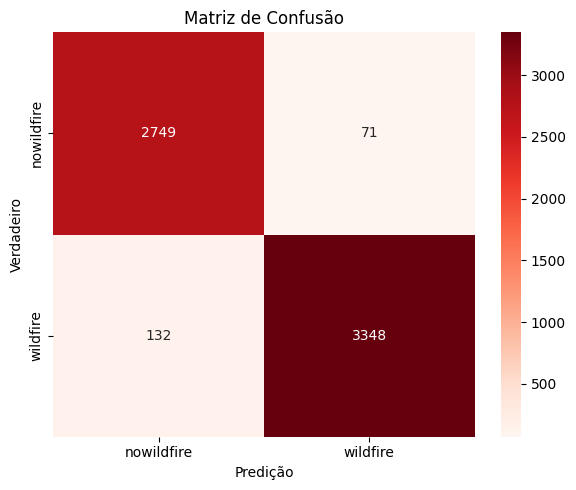

Relatório de classificação:

              precision    recall  f1-score   support

  nowildfire       0.95      0.97      0.96      2820
    wildfire       0.98      0.96      0.97      3480

    accuracy                           0.97      6300
   macro avg       0.97      0.97      0.97      6300
weighted avg       0.97      0.97      0.97      6300



In [23]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

print("Relatório de classificação:\n")
print(classification_report(rotulos, predicoes, target_names=class_labels))

### Arquitetura II - Modelo pré treinado do torchgeo (ResNet18 Sentinel 2 RGB SECO)

In [9]:
weights_seco = ResNet18_Weights.SENTINEL2_RGB_SECO

In [10]:
model_seco = resnet18(weights=weights_seco)

Downloading: "https://hf.co/torchgeo/resnet18_sentinel2_rgb_seco/resolve/f8dcee692cf7142163b55a5c197d981fe0e717a0/resnet18_sentinel2_rgb_seco-cefca942.pth" to /Users/mariahelena/.cache/torch/hub/checkpoints/resnet18_sentinel2_rgb_seco-cefca942.pth
100%|██████████| 42.7M/42.7M [00:04<00:00, 9.16MB/s]


In [11]:
# congelando camadas 
for param in model_seco.parameters():
    param.requires_grad = False

In [12]:
# substituindo a ultima camada para o problema atual 
classes = len(train_dataset.classes)
model_seco.fc = nn.Linear(model_seco.fc.in_features, classes)

for param in model_seco.fc.parameters():
    param.requires_grad = True

model_seco = model_seco.to(device)

In [19]:
criterion_seco = nn.CrossEntropyLoss()
optimizer_seco = optim.Adam(model_seco.fc.parameters(), lr=0.001)

In [20]:
num_epochs = 10
for epoch in range(num_epochs):
    model_seco.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, rotulos in train_loader:
        images, rotulos = images.to(device), rotulos.to(device)

        optimizer.zero_grad()
        outputs = model_seco(images)
        loss = criterion(outputs, rotulos)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == rotulos).sum().item()
        total += rotulos.size(0)

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Validação
    model_seco.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, rotulos in valid_loader:
            images, rotulos = images.to(device), rotulos.to(device)
            outputs = model_seco(images)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == rotulos).sum().item()
            val_total += rotulos.size(0)
    val_acc = 100 * val_correct / val_total

    # Resultado 
    print(f"Época {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

Época 1/10 | Loss: 0.6863 | Train Acc: 57.05% | Val Acc: 58.73%
Época 2/10 | Loss: 0.6868 | Train Acc: 57.27% | Val Acc: 58.87%
Época 3/10 | Loss: 0.6862 | Train Acc: 56.91% | Val Acc: 58.25%
Época 4/10 | Loss: 0.6865 | Train Acc: 56.97% | Val Acc: 59.10%
Época 5/10 | Loss: 0.6861 | Train Acc: 56.86% | Val Acc: 57.51%
Época 6/10 | Loss: 0.6866 | Train Acc: 56.86% | Val Acc: 58.98%
Época 7/10 | Loss: 0.6863 | Train Acc: 57.00% | Val Acc: 58.70%
Época 8/10 | Loss: 0.6860 | Train Acc: 57.01% | Val Acc: 59.03%
Época 9/10 | Loss: 0.6868 | Train Acc: 56.87% | Val Acc: 58.11%
Época 10/10 | Loss: 0.6868 | Train Acc: 56.91% | Val Acc: 58.13%


In [36]:
acertos, total = 0, 0
with torch.no_grad():
    for images, rotulos in test_loader:
        images, rotulos = images.to(device), rotulos.to(device)
        preds = model_seco(images).argmax(1)
        acertos += (preds == rotulos).sum().item()
        total += rotulos.size(0)
print(f"Acurácia no teste: {100 * acertos / total:.2f}%")

Acurácia no teste: 59.11%


In [34]:
model_seco.eval()

predicoes = []
rotulos = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_seco(images)
        _, preds = torch.max(outputs, 1)
        predicoes.extend(preds.cpu().numpy())
        rotulos.extend(labels.cpu().numpy())

predicoes = np.array(predicoes)
rotulos = np.array(rotulos)

class_labels = test_loader.dataset.classes

cm2 = confusion_matrix(rotulos, predicoes)

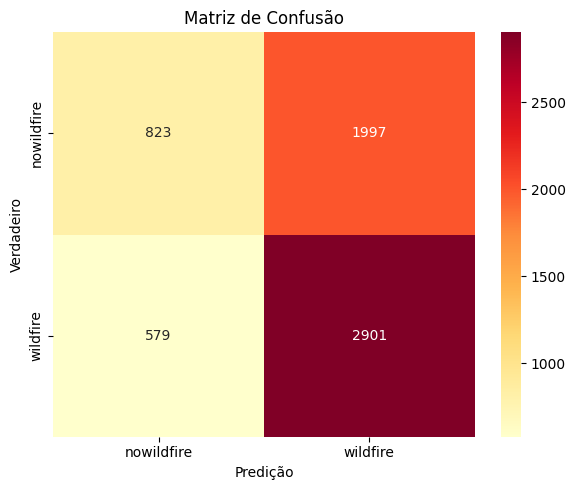

Relatório de classificação:

              precision    recall  f1-score   support

  nowildfire       0.59      0.29      0.39      2820
    wildfire       0.59      0.83      0.69      3480

    accuracy                           0.59      6300
   macro avg       0.59      0.56      0.54      6300
weighted avg       0.59      0.59      0.56      6300



In [35]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

print("Relatório de classificação:\n")
print(classification_report(rotulos, predicoes, target_names=class_labels))

### Arquitetura III - ResNet18 ImageNet

In [23]:
model_img = resnet18(pretrained=True)

In [24]:
# congelando camadas 
for param in model_img.parameters():
    param.requires_grad = False

In [25]:
# substituindo a ultima camada para o problema atual 
classes = len(train_dataset.classes)
model_img.fc = nn.Linear(model_img.fc.in_features, classes)

for param in model_img.fc.parameters():
    param.requires_grad = True

model_img = model_img.to(device)

In [26]:
criterion_img = nn.CrossEntropyLoss()
optimizer_img = optim.Adam(model_img.fc.parameters(), lr=0.001)

In [27]:
num_epochs = 10
for epoch in range(num_epochs):
    model_img.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, rotulos in train_loader:
        images, rotulos = images.to(device), rotulos.to(device)

        optimizer.zero_grad()
        outputs = model_img(images)
        loss = criterion(outputs, rotulos)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == rotulos).sum().item()
        total += rotulos.size(0)

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Validação
    model_img.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, rotulos in valid_loader:
            images, rotulos = images.to(device), rotulos.to(device)
            outputs = model_img(images)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == rotulos).sum().item()
            val_total += rotulos.size(0)
    val_acc = 100 * val_correct / val_total

    # Resultado 
    print(f"Época {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

Época 1/10 | Loss: 0.7234 | Train Acc: 44.42% | Val Acc: 40.92%
Época 2/10 | Loss: 0.7237 | Train Acc: 44.18% | Val Acc: 41.95%
Época 3/10 | Loss: 0.7236 | Train Acc: 44.15% | Val Acc: 41.21%
Época 4/10 | Loss: 0.7236 | Train Acc: 44.27% | Val Acc: 42.13%
Época 5/10 | Loss: 0.7239 | Train Acc: 43.90% | Val Acc: 41.56%
Época 6/10 | Loss: 0.7231 | Train Acc: 44.56% | Val Acc: 39.94%
Época 7/10 | Loss: 0.7232 | Train Acc: 44.38% | Val Acc: 40.73%
Época 8/10 | Loss: 0.7237 | Train Acc: 44.29% | Val Acc: 40.87%
Época 9/10 | Loss: 0.7231 | Train Acc: 44.27% | Val Acc: 42.46%
Época 10/10 | Loss: 0.7236 | Train Acc: 44.49% | Val Acc: 38.33%


In [28]:
acertos, total = 0, 0
with torch.no_grad():
    for images, rotulos in test_loader:
        images, rotulos = images.to(device), rotulos.to(device)
        preds = model_img(images).argmax(1)
        acertos += (preds == rotulos).sum().item()
        total += rotulos.size(0)
print(f"Acurácia no teste: {100 * acertos / total:.2f}%")

Acurácia no teste: 38.30%


In [29]:
model_img.eval()

predicoes = []
rotulos = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_img(images)
        _, preds = torch.max(outputs, 1)
        predicoes.extend(preds.cpu().numpy())
        rotulos.extend(labels.cpu().numpy())

predicoes = np.array(predicoes)
rotulos = np.array(rotulos)

class_labels = test_loader.dataset.classes

cm3 = confusion_matrix(rotulos, predicoes)

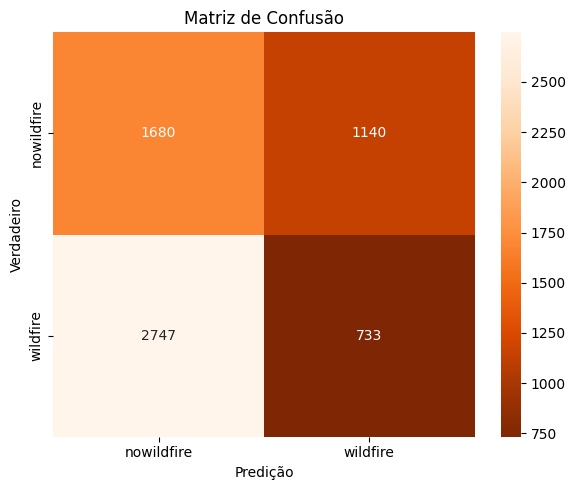

Relatório de classificação:

              precision    recall  f1-score   support

  nowildfire       0.38      0.60      0.46      2820
    wildfire       0.39      0.21      0.27      3480

    accuracy                           0.38      6300
   macro avg       0.39      0.40      0.37      6300
weighted avg       0.39      0.38      0.36      6300



In [31]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges_r',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

print("Relatório de classificação:\n")
print(classification_report(rotulos, predicoes, target_names=class_labels))